In [1]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import utils

In [2]:
def stratify_dfcol(df, colname, value):
    #return pd_utils.select_dfrows(df, [f"$({colname}) == {value}"])
    return df.loc[df[colname] == value]

def stratify_dfcols(df, condition_list):
    for (colname, value) in condition_list:
        df = stratify_dfcol(df, colname, value)
    return df

def stratify_dfcols_in_list(df, colname, values):
    return df.loc[df[colname].isin(values)]

In [3]:
dsc_output = "/gpfs/commons/home/sbanerjee/simdata/sparse-regression/gradvi-experiments/linreg_corr_dense"
dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
elbopkl   = os.path.join("../dsc/results", dsc_fname + "_elbo.pkl")
dscoutpkl = os.path.join("../dsc/results", dsc_fname + "_dscout.pkl")
msepkl    = os.path.join("../dsc/results", dsc_fname + "_mse.pkl")
niterpkl  = os.path.join("../dsc/results", dsc_fname + "_niter.pkl")
dscout    = pd.read_pickle(dscoutpkl)

refresh_pickle = False

print(db)

/gpfs/commons/home/sbanerjee/simdata/sparse-regression/gradvi-experiments/linreg_corr_dense/linreg_corr_dense.db


In [4]:
target = ["simulate", "simulate.sfix", "simulate.pve", "simulate.se", "simulate.dims", "fit", "fit.DSC_TIME"]
#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

In [5]:
qp = dscQP(db, target, condition)
df = qp.output_table
df

,DSC,simulate,simulate.sfix,simulate.se:output,simulate.pve,simulate.output.file,simulate.dims,fit,fit.output.file,fit.DSC_TIME:output
0,1,blockdiag,200,blockdiag/blockdiag_1,0.4,blockdiag/blockdiag_1,"(500,10000)",mr_ash,mr_ash/blockdiag_1_mr_ash_1,mr_ash/blockdiag_1_mr_ash_1
1,1,blockdiag,200,blockdiag/blockdiag_2,0.6,blockdiag/blockdiag_2,"(500,10000)",mr_ash,mr_ash/blockdiag_2_mr_ash_1,mr_ash/blockdiag_2_mr_ash_1
2,1,blockdiag,200,blockdiag/blockdiag_3,0.8,blockdiag/blockdiag_3,"(500,10000)",mr_ash,mr_ash/blockdiag_3_mr_ash_1,mr_ash/blockdiag_3_mr_ash_1
3,2,blockdiag,200,blockdiag/blockdiag_4,0.4,blockdiag/blockdiag_4,"(500,10000)",mr_ash,mr_ash/blockdiag_4_mr_ash_1,mr_ash/blockdiag_4_mr_ash_1
4,2,blockdiag,200,blockdiag/blockdiag_5,0.6,blockdiag/blockdiag_5,"(500,10000)",mr_ash,mr_ash/blockdiag_5_mr_ash_1,mr_ash/blockdiag_5_mr_ash_1
...,...,...,...,...,...,...,...,...,...,...
175,9,blockdiag,200,blockdiag/blockdiag_26,0.6,blockdiag/blockdiag_26,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_26_lasso_...,gradvi_compound_lasso_init/blockdiag_26_lasso_...
176,9,blockdiag,200,blockdiag/blockdiag_27,0.8,blockdiag/blockdiag_27,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_27_lasso_...,gradvi_compound_lasso_init/blockdiag_27_lasso_...
177,10,blockdiag,200,blockdiag/blockdiag_28,0.4,blockdiag/blockdiag_28,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_28_lasso_...,gradvi_compound_lasso_init/blockdiag_28_lasso_...
178,10,blockdiag,200,blockdiag/blockdiag_29,0.6,blockdiag/blockdiag_29,"(500,10000)",gradvi_compound_lasso_init,gradvi_compound_lasso_init/blockdiag_29_lasso_...,gradvi_compound_lasso_init/blockdiag_29_lasso_...


In [8]:
def read_result(df, method):
    '''
    must be a single row after method selection
    '''
    dfm = stratify_dfcol(df, "fit", method)
    assert(dfm.shape[0] == 1)
    fprefix = dfm['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(dsc_output, f"{fprefix}.{ext}")
    data = dsc_io.load_dsc(fname)
    return data


def get_niter_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['niter']
    else:
        return data['model']['fit']['iter']
    

def get_convergence_from_result(data, method, mrash_maxiter = 2000):
    '''
    1: converged
    2: abnormal termination
    3: number of iterations reached limit
    4: unknown
    '''
    if method.startswith('gradvi'):
        success = data['model']['success']
        if success:
            conv_status = 1
        else:
            conv_message = data['model']['fitobj']['message']
            if "ITERATIONS REACHED LIMIT" in conv_message:
                conv_status = 3
            elif "ABNORMAL_TERMINATION_IN_LNSRCH" in conv_message:
                conv_status = 2
            else:
                conv_status = 4
    else:
        niter = data['model']['fit']['iter']
        if niter == mrash_maxiter:
            conv_status = 3
        else:
            conv_status = 1
    return conv_status

    
def get_niter_df(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    data = read_result(dfs0, method)
                    niter = get_niter_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(niter)
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

In [9]:
def get_elbo_from_result(data, method):
    if method.startswith('gradvi'):
        return data['model']['elbo_path'][-1]
    else:
        return data['model']['fit']['varobj'][-1]
    

def get_mse_from_dscout(df, sfix, pve, dsc, method):
    dfrows = stratify_dfcols(df, 
                             [("simulate.sfix", sfix), 
                              ("simulate.pve", pve), 
                              ("DSC", dsc), 
                              ("fit", method)])
    mse = dfrows[~dfrows['mse.err'].isnull()]['mse.err'].values
    if len(mse) == 1:
        return mse[0]
    else:
        print ("Error fetching value")
        return mse[0]
    
def get_elbodf(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               **{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    data = read_result(dfs0, method)
                    elbo = get_elbo_from_result(data, method)
                    conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(elbo)    
                    resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

def get_msedf(elbodf, dscdf):
    methods = [x[:-7] for x in list(elbodf.columns) if x.endswith("_status")]
    msedict = elbodf.to_dict()
    ikeys = list(msedict['simulate.sfix'].keys())
    for method in methods:
        for i in ikeys:
            mse = get_mse_from_dscout(dscout, 
                          msedict['simulate.sfix'][i], 
                          msedict['simulate.pve'][i],
                          msedict['DSC'][i], 
                          method)
            msedict[method][i] = mse
    return pd.DataFrame.from_dict(msedict)

In [10]:
refresh_pickle = True

if refresh_pickle:
    niterdf = get_niter_df(df)
    niterdf.to_pickle(niterpkl)
else:
    niterdf = pd.read_pickle(niterpkl)
    
refresh_pickle = False

INFO: cffi mode is CFFI_MODE.ANY
INFO: R home found: /nfs/sw/R/R-4.2.3/lib64/R
INFO: R library path: /nfs/sw/R/R-4.2.3/lib64/R/lib:/usr/local/lib64:/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.352.b08-2.el7_9.x86_64/jre/lib/amd64/server:/nfs/sw/R/R-4.2.3/lib64/R/lib:/nfs/sw/openmpi/openmpi-4.1.4/lib:/nfs/sw/openblas/openblas-0.2.19/lib:/nfs/sw/openblas/openblas-0.2.19/:/nfs/sw/gcc/gcc-11.2.0/lib/gcc/x86_64-pc-linux-gnu/11.2.0:/nfs/sw/gcc/gcc-11.2.0/lib/../lib64:/nfs/sw/gcc/gcc-11.2.0/lib64:/nfs/sw/gcc/gcc-11.2.0/libexec/gcc/x86_64-pc-linux-gnu/11.2.0:/opt/slurm/slurm-20.11.0/lib64:/opt/slurm/pe2/slurm/centos7/lib64:/opt/slurm/slurm-20.11.0/lib64:/nfs/sw/vim/vim-8.2.0/lib:/opt/slurm/slurm-20.11.0/lib64:
INFO: LD_LIBRARY_PATH: /nfs/sw/R/R-4.2.3/lib64/R/lib:/nfs/sw/openmpi/openmpi-4.1.4/lib:/nfs/sw/openblas/openblas-0.2.19/lib:/nfs/sw/openblas/openblas-0.2.19/:/nfs/sw/gcc/gcc-11.2.0/lib/gcc/x86_64-pc-linux-gnu/11.2.0:/nfs/sw/gcc/gcc-11.2.0/lib/../lib64:/nfs/sw/gcc/gcc-11.2.0/lib64:/nfs/sw/gcc/gc

In [11]:
niterdf

,simulate.sfix,simulate.pve,DSC,mr_ash,mr_ash_lasso_init,gradvi_direct,gradvi_compound,gradvi_direct_lasso_init,gradvi_compound_lasso_init,mr_ash_status,mr_ash_lasso_init_status,gradvi_direct_status,gradvi_compound_status,gradvi_direct_lasso_init_status,gradvi_compound_lasso_init_status
0,200,0.4,1,127,114,178,181,286,39,1,1,1,1,1,1
1,200,0.4,2,706,119,203,189,696,147,1,1,1,1,1,1
2,200,0.4,3,310,159,139,225,473,111,1,1,1,1,1,1
3,200,0.4,4,114,103,202,27,215,34,1,1,1,1,1,1
4,200,0.4,5,124,216,188,158,506,41,1,1,1,1,1,1
5,200,0.4,6,136,134,140,170,254,137,1,1,1,1,1,1
6,200,0.4,7,120,106,136,139,326,129,1,1,1,1,1,1
7,200,0.4,8,97,76,159,33,400,40,1,1,1,1,1,1
8,200,0.4,9,183,174,124,211,469,228,1,1,1,1,1,1
9,200,0.4,10,138,131,162,224,1174,80,1,1,1,1,1,1


In [12]:
if refresh_pickle:
    elbodf = get_elbodf(df)
    elbodf.to_pickle(elbopkl)
else:
    elbodf = pd.read_pickle(elbopkl)

In [13]:
if refresh_pickle:
    msedf = get_msedf(elbodf, dscout)
    msedf.to_pickle(msepkl)
else:
    msedf = pd.read_pickle(msepkl)

In [14]:
dscout

,DSC,simulate,simulate.dims,simulate.se,simulate.sfix,simulate.pve,fit,fit.DSC_TIME,mse.err,coef_mse.err
0,1,blockdiag,"(500,10000)",15.810438,200,0.4,mr_ash,14.297000,263.808624,NaN
1,1,blockdiag,"(500,10000)",7.270258,200,0.6,mr_ash,19.311000,71.240069,NaN
2,1,blockdiag,"(500,10000)",2.990619,200,0.8,mr_ash,31.882000,20.320874,NaN
3,2,blockdiag,"(500,10000)",23.305761,200,0.4,mr_ash,42.945000,583.867850,NaN
4,2,blockdiag,"(500,10000)",9.072537,200,0.6,mr_ash,19.563000,91.901117,NaN
...,...,...,...,...,...,...,...,...,...,...
355,9,blockdiag,"(500,10000)",10.200535,200,0.6,gradvi_compound_lasso_init,58.407143,NaN,0.027507
356,9,blockdiag,"(500,10000)",14.145646,200,0.8,gradvi_compound_lasso_init,64.024360,NaN,0.040838
357,10,blockdiag,"(500,10000)",12.505696,200,0.4,gradvi_compound_lasso_init,39.126649,NaN,0.022892
358,10,blockdiag,"(500,10000)",6.863785,200,0.6,gradvi_compound_lasso_init,38.119295,NaN,0.022842


In [15]:
#dscout_unique = dscout[dscout['mse.err'].notna()]

def get_runtime_from_dscout(df, sfix, pve, dsc, method):
    dfrows = stratify_dfcols(df, 
                             [("simulate.sfix", sfix), 
                              ("simulate.pve", pve), 
                              ("DSC", dsc), 
                              ("fit", method)])
    runtime = dfrows[~dfrows['mse.err'].isnull()]['fit.DSC_TIME'].values
    
    if len(runtime) == 1:
        return runtime[0]
    else:
        print ("Error fetching value")
        return runtime[0]

def get_runtimedf(df):
    methods = df['fit'].unique()
    sfixs   = df['simulate.sfix'].unique()
    pves    = df['simulate.pve'].unique()
    resdict = {'simulate.sfix': [], 'simulate.pve': [], 'DSC': [], 
               **{x: [] for x in methods}, 
               #**{f"{x}_status": [] for x in methods}
              }
    for pve in pves:
        for sfix in sfixs:
            dfs = stratify_dfcols(df, [('simulate.sfix', sfix), ("simulate.pve", pve)])

            dscids = dfs['DSC'].unique()
            for idsc in dscids:
                dfs0 = stratify_dfcol(dfs, 'DSC', idsc)
                resdict['simulate.sfix'].append(sfix)
                resdict['simulate.pve'].append(pve)
                resdict['DSC'].append(idsc)
                for method in methods:
                    #data = read_result(dfs0, method)
                    runtime = get_runtime_from_dscout(dscout, sfix, pve, idsc, method)
                    #conv_status = get_convergence_from_result(data, method)
                    resdict[method].append(runtime)
                    #resdict[f"{method}_status"].append(conv_status)
    return pd.DataFrame.from_dict(resdict)

runtimedf = get_runtimedf(dscout)

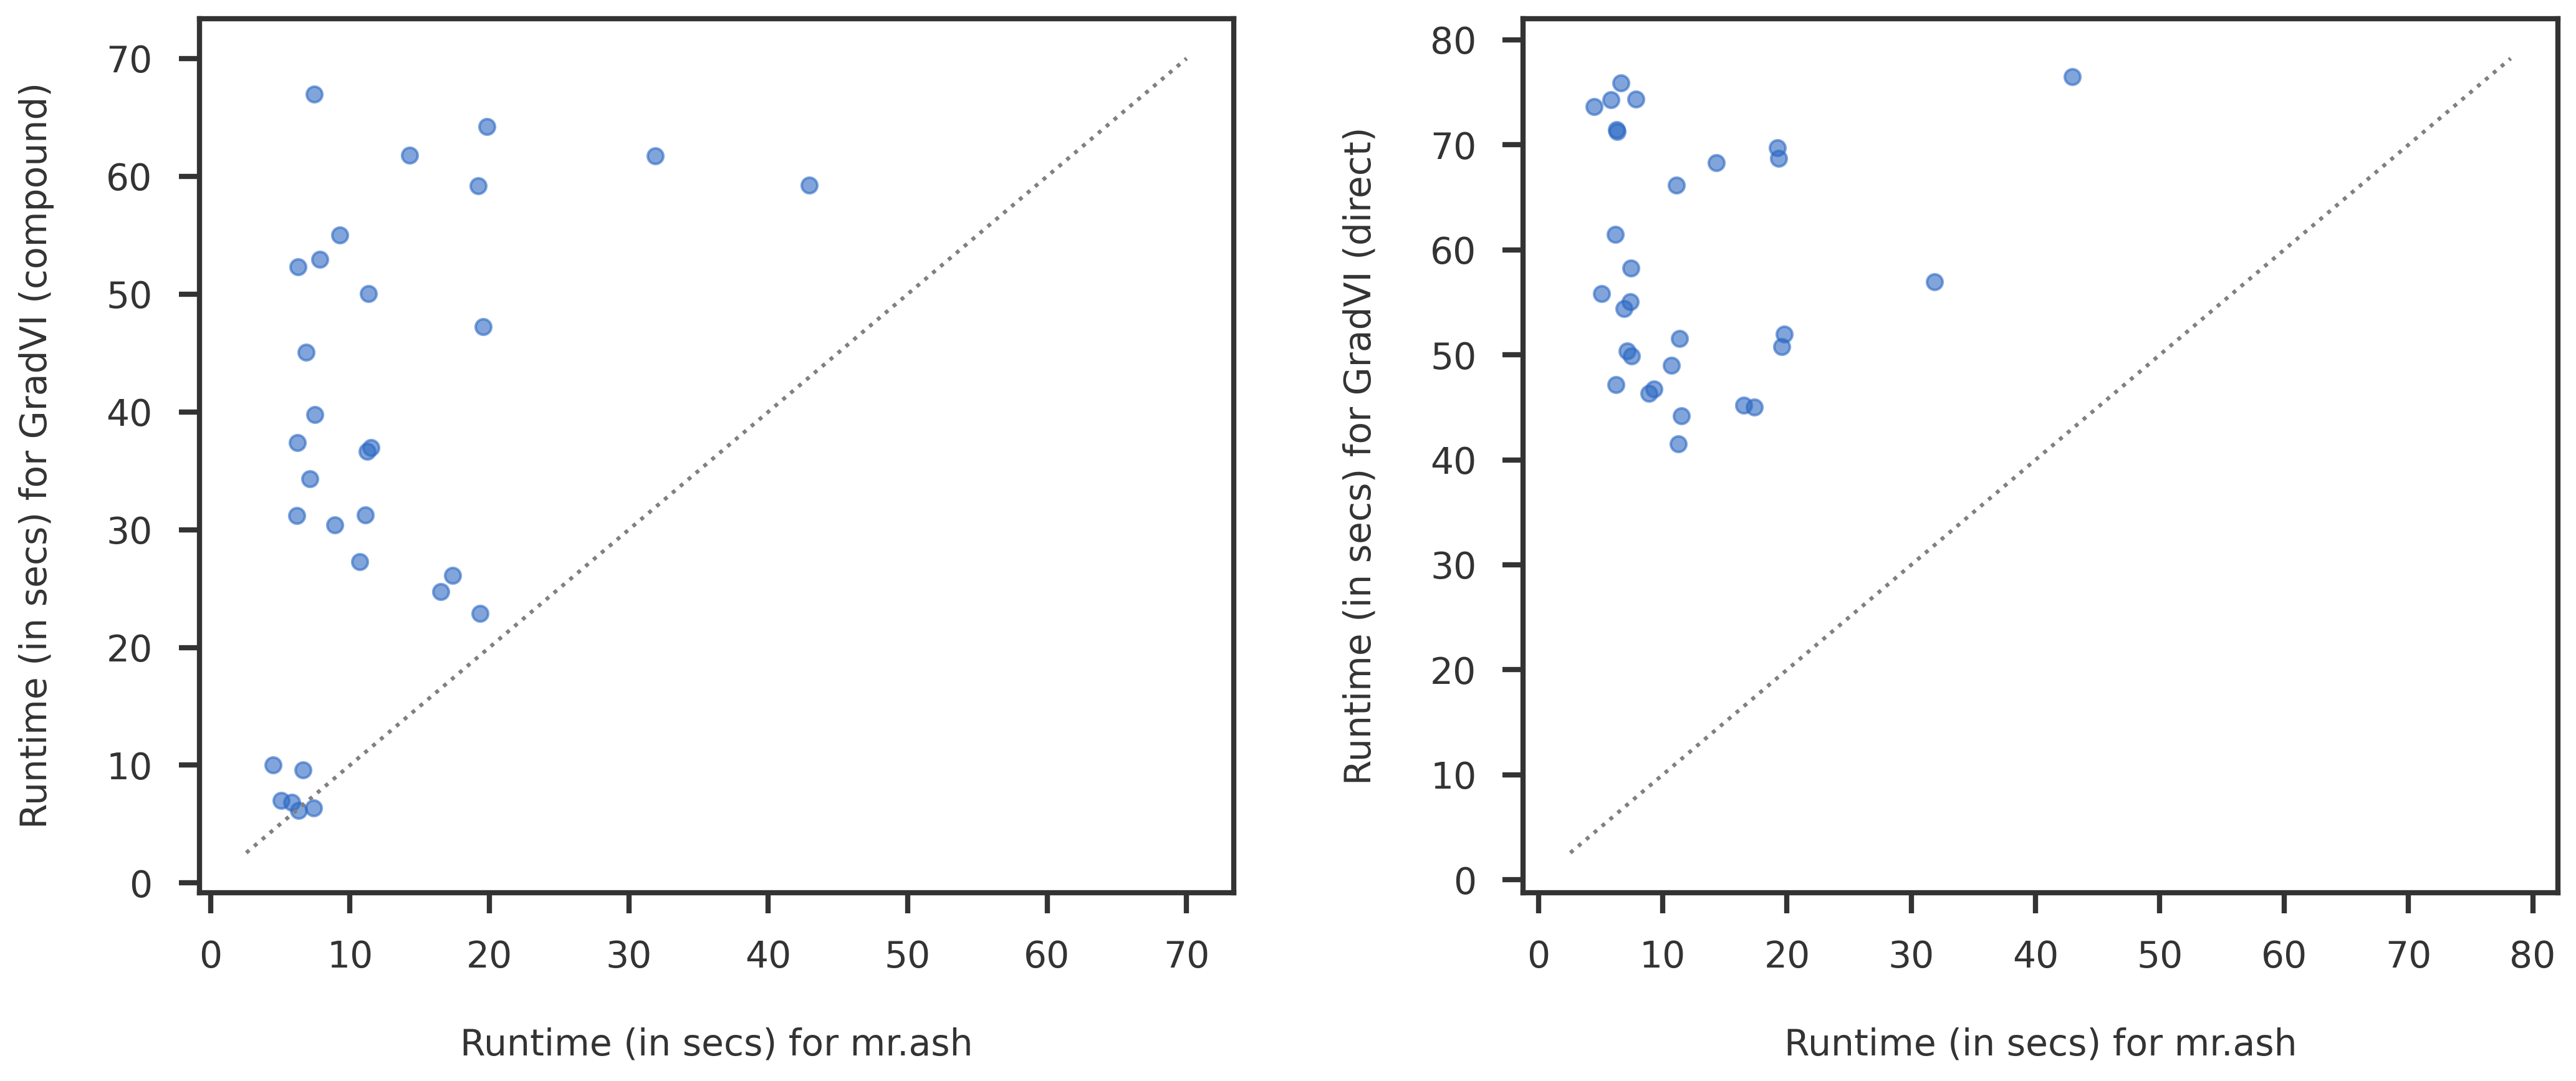

In [19]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax1.scatter(msedf['mr_ash_lasso_init'], msedf['gradvi_compound_lasso_init'])
ax1.scatter(runtimedf['mr_ash'], runtimedf['gradvi_compound'], alpha = 0.6)
#ax1.hist(elbodf['mr_ash_lasso_init'] - elbodf['gradvi_compound_lasso_init'])
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("Runtime (in secs) for mr.ash")
ax1.set_ylabel("Runtime (in secs) for GradVI (compound)")

ax2.scatter(runtimedf['mr_ash'], runtimedf['gradvi_direct'], alpha = 0.6)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("Runtime (in secs) for mr.ash")
ax2.set_ylabel("Runtime (in secs) for GradVI (direct)")

plt.tight_layout(w_pad = 3.0)
#utils.saveplot(fig, "linreg_corr_compare_runtime_gradvi_cavi")
plt.show()

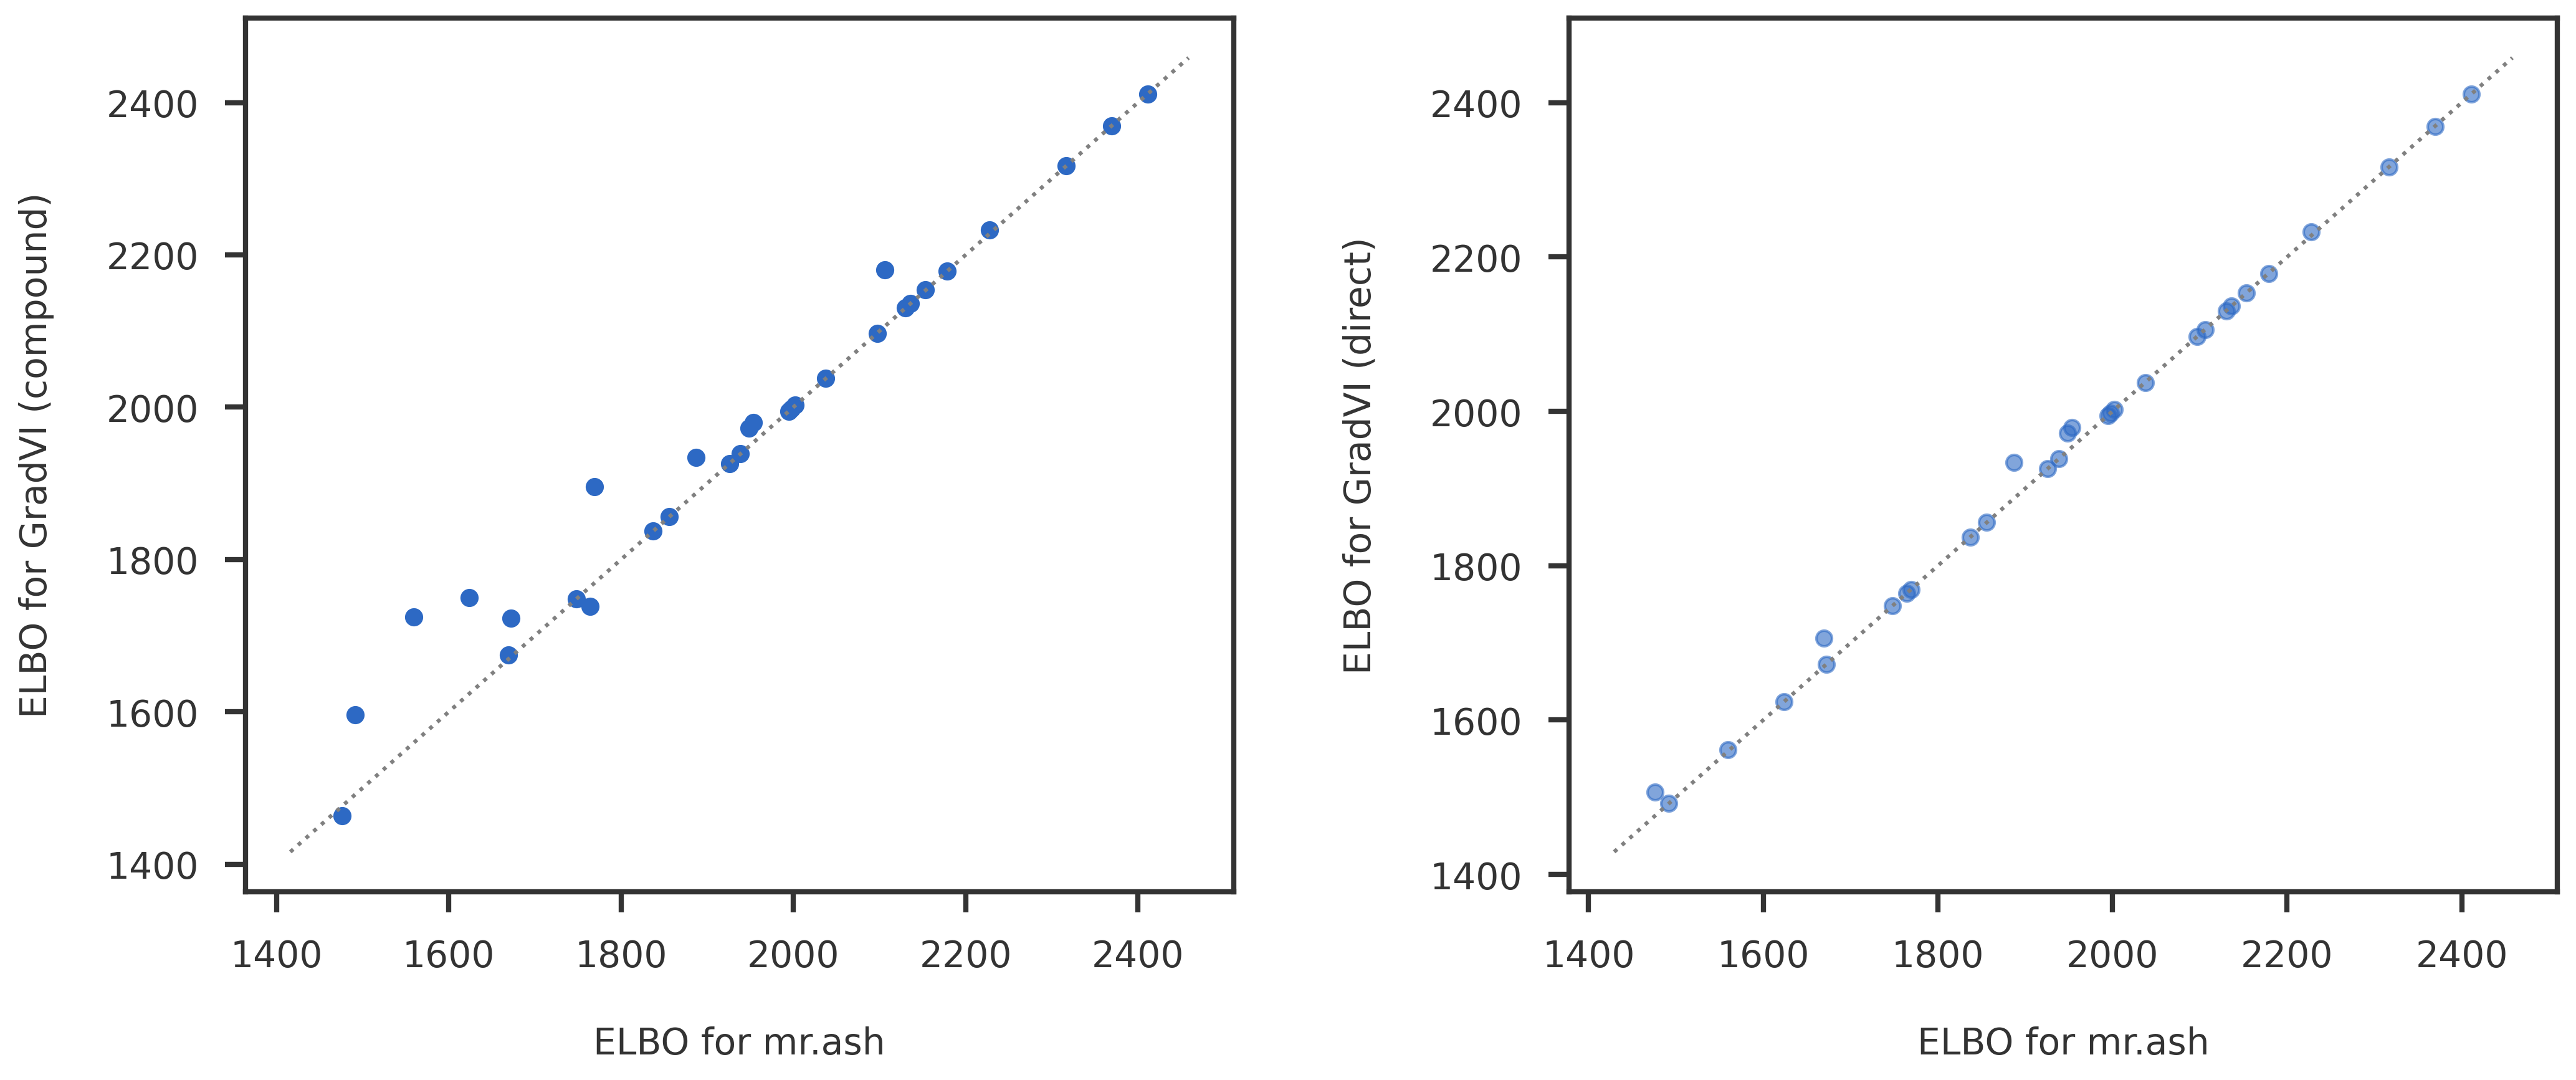

In [20]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax1.scatter(msedf['mr_ash_lasso_init'], msedf['gradvi_compound_lasso_init'])
#ax1.scatter(runtimedf['mr_ash_lasso_init'], runtimedf['gradvi_compound_lasso_init'], alpha = 0.6)
ax1.scatter(elbodf['mr_ash_lasso_init'], elbodf['gradvi_compound'])
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("ELBO for mr.ash")
ax1.set_ylabel("ELBO for GradVI (compound)")

#ax2.scatter(runtimedf['mr_ash_lasso_init'], runtimedf['gradvi_direct_lasso_init'], alpha = 0.6)
ax2.scatter(elbodf['mr_ash_lasso_init'], elbodf['gradvi_direct'], alpha = 0.6)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("ELBO for mr.ash")
ax2.set_ylabel("ELBO for GradVI (direct)")

plt.tight_layout(w_pad = 3.0)
#utils.saveplot(fig, "linreg_corr_compare_elbo_gradvi_cavi")
plt.show()

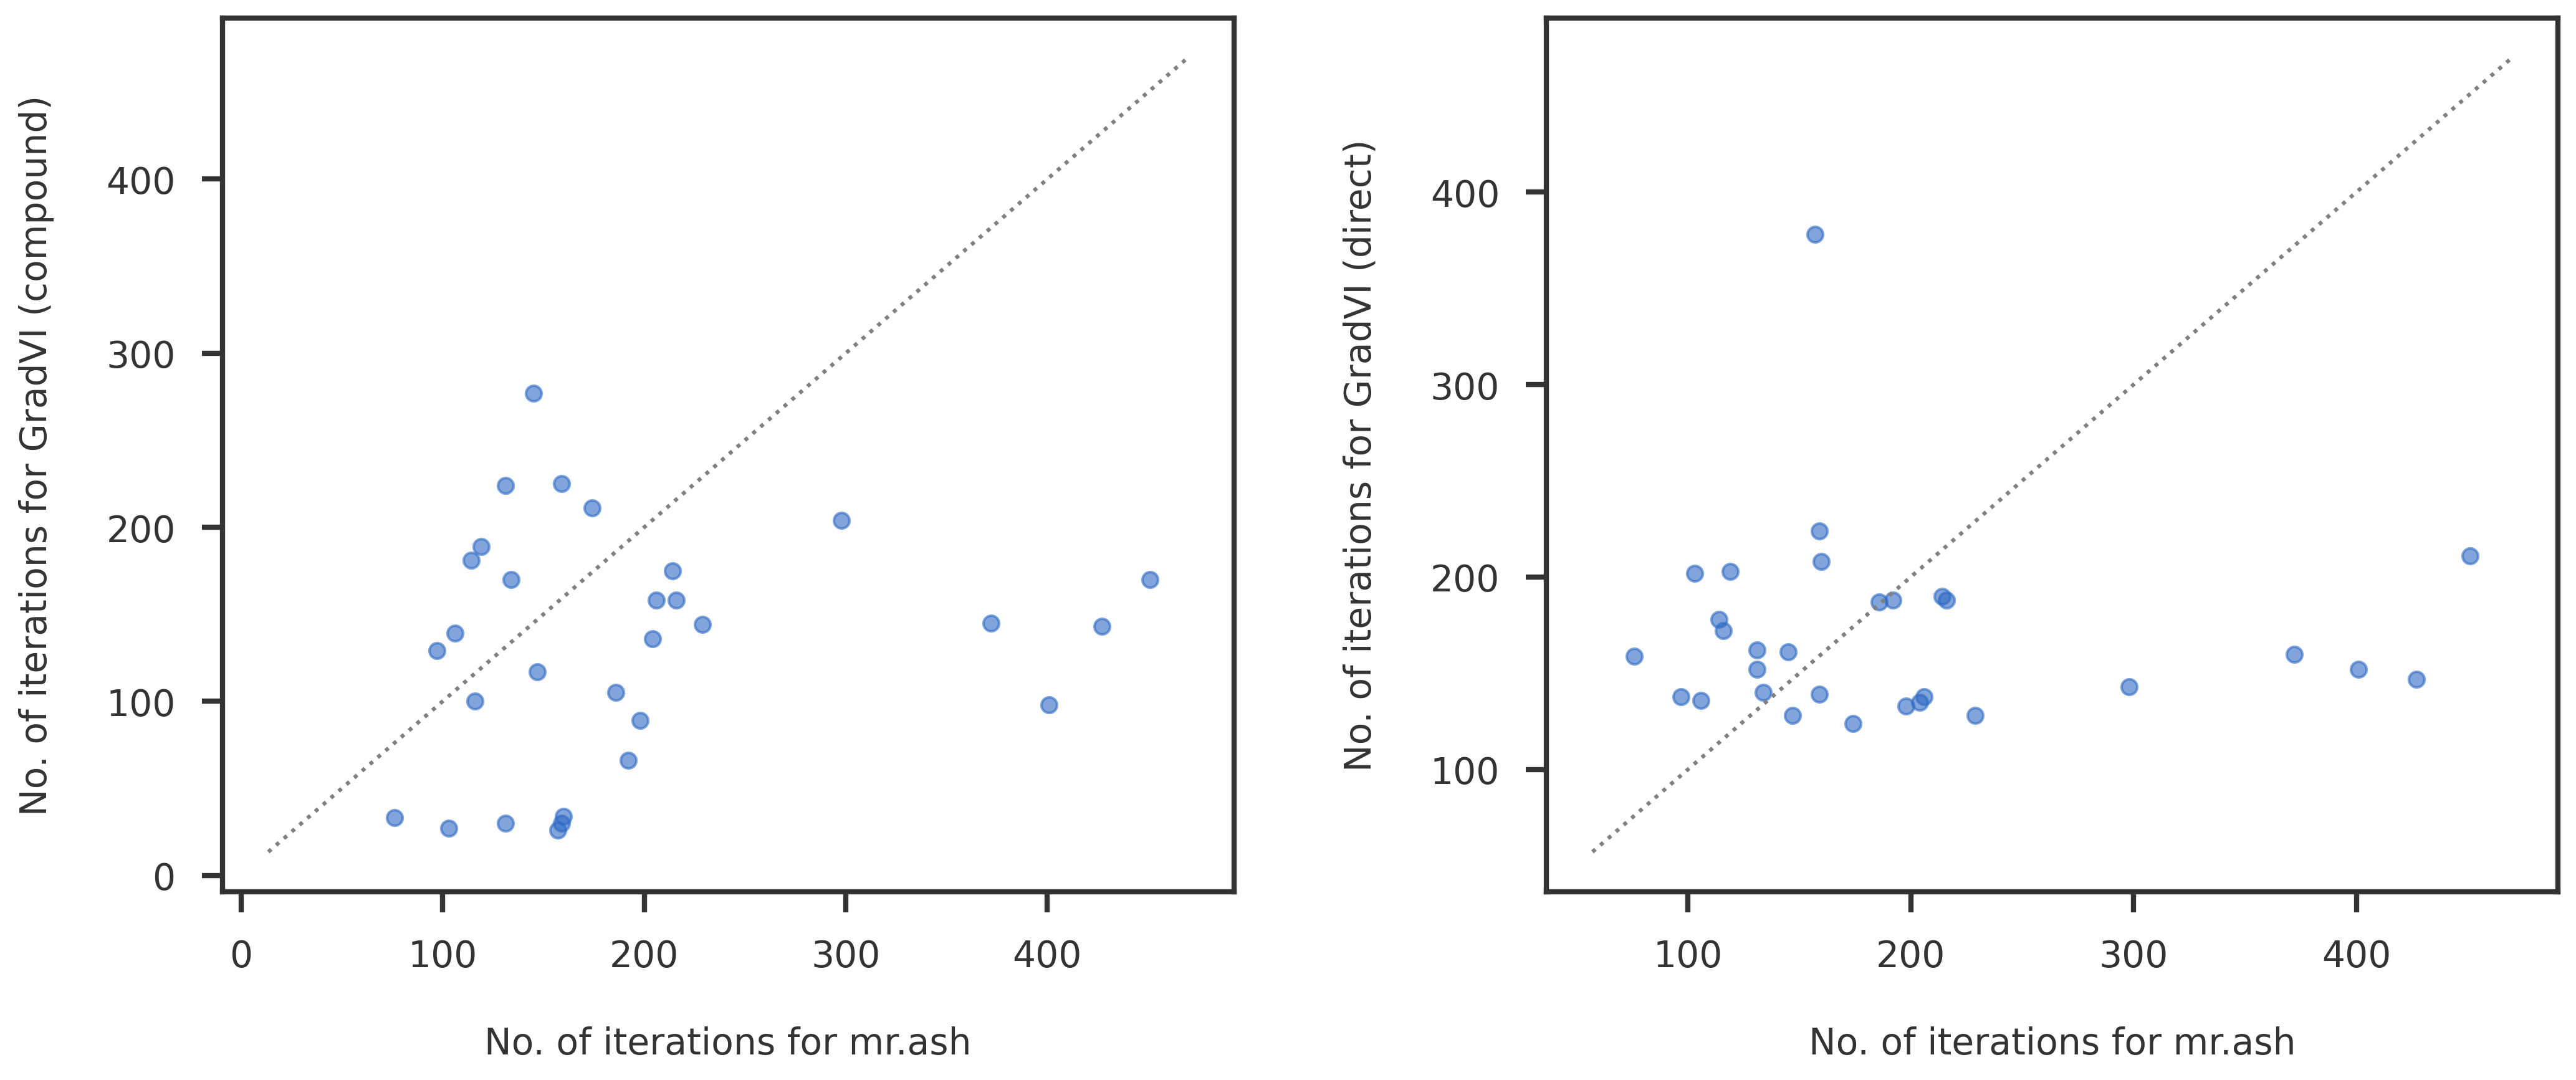

In [24]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

#ax1.scatter(msedf['mr_ash_lasso_init'], msedf['gradvi_compound_lasso_init'])
ax1.scatter(niterdf['mr_ash_lasso_init'], niterdf['gradvi_compound'], alpha = 0.6)
#ax1.hist(elbodf['mr_ash_lasso_init'] - elbodf['gradvi_compound_lasso_init'])
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("No. of iterations for mr.ash")
ax1.set_ylabel("No. of iterations for GradVI (compound)")

ax2.scatter(niterdf['mr_ash_lasso_init'], niterdf['gradvi_direct'], alpha = 0.6)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel("No. of iterations for mr.ash")
ax2.set_ylabel("No. of iterations for GradVI (direct)")

plt.tight_layout(w_pad = 3.0)
#utils.saveplot(fig, "linreg_corr_compare_niter_gradvi_cavi")
plt.show()